In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-05-05 11:19:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.96.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.3’

jena_climate_2009_2 100%[===================>]  12.94M  10.9MB/s    in 1.2s    

2022-05-05 11:19:18 (10.9 MB/s) - ‘jena_climate_2009_2016.csv.zip.3’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [5]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

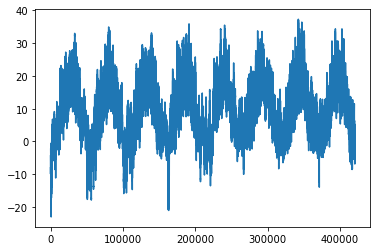

In [6]:
plt.plot(range(len(temperature)), temperature)

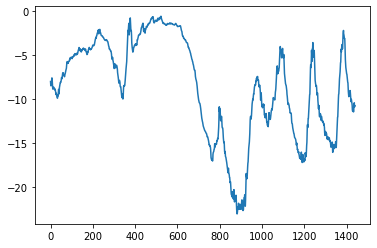

In [7]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2022-05-05 11:21:38.976021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-05 11:21:38.976151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-05 11:21:39.008835: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples+num_val_samples
)

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-05-05 13:57:50.863845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 13.9506 - mae: 2.8810

2022-05-05 13:57:58.511136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 11s 13ms/step - loss: 13.9506 - mae: 2.8810 - val_loss: 12.0439 - val_mae: 2.7672
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 9.5315 - mae: 2.4283 - val_loss: 10.4856 - val_mae: 2.5669
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 8.7283 - mae: 2.3245 - val_loss: 10.8568 - val_mae: 2.6150
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 8.2413 - mae: 2.2596 - val_loss: 14.6541 - val_mae: 3.0616
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 7.9166 - mae: 2.2146 - val_loss: 11.4828 - val_mae: 2.6938
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 7.6792 - mae: 2.1797 - val_loss: 10.1496 - val_mae: 2.5307
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 7.4449 - mae: 2.1466 - val_loss: 11.0392 - val_mae: 2.6423
Epoch 8/10
819/819 [==============================] - 11s 13ms/st

2022-05-05 13:59:45.192220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 3s 8ms/step - loss: 11.0079 - mae: 2.6042
Test MAE: 2.60


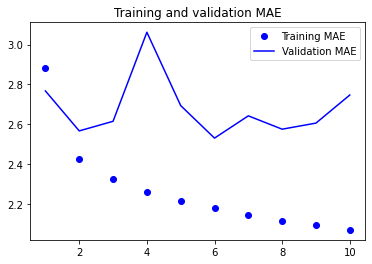

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-05-05 14:06:37.855895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 23.0730 - mae: 3.7559

2022-05-05 14:06:47.923959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 14s 15ms/step - loss: 23.0730 - mae: 3.7559 - val_loss: 14.9547 - val_mae: 3.0810
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 15.9176 - mae: 3.1747 - val_loss: 14.8153 - val_mae: 3.0583
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 14.3829 - mae: 3.0083 - val_loss: 14.4916 - val_mae: 2.9929
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 13.3899 - mae: 2.8975 - val_loss: 15.2947 - val_mae: 3.1064
Epoch 5/10
819/819 [==============================] - 14s 16ms/step - loss: 12.6689 - mae: 2.8199 - val_loss: 15.3116 - val_mae: 3.0607
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 12.0862 - mae: 2.7524 - val_loss: 14.2883 - val_mae: 2.9802
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 11.6238 - mae: 2.6986 - val_loss: 15.3120 - val_mae: 3.0743
Epoch 8/10
819/819 [==============================] - 12s 1

2022-05-05 14:08:43.102251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 4s 8ms/step - loss: 15.7625 - mae: 3.1655
Test MAE: 3.17


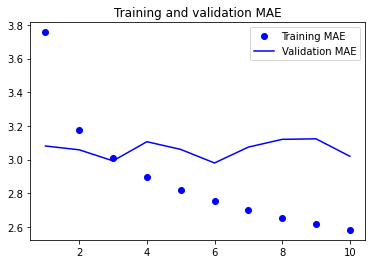

In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 8)             392 

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-05-05 14:14:27.079651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 14:14:27.339385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 14:14:28.483041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 40.8901 - mae: 4.6405

2022-05-05 14:14:57.428728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 14:14:57.551173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 39s 45ms/step - loss: 40.8901 - mae: 4.6405 - val_loss: 12.5285 - val_mae: 2.6821
Epoch 2/10
819/819 [==============================] - 35s 43ms/step - loss: 10.7895 - mae: 2.5617 - val_loss: 10.2335 - val_mae: 2.4580
Epoch 3/10
819/819 [==============================] - 36s 43ms/step - loss: 9.6175 - mae: 2.4276 - val_loss: 10.4453 - val_mae: 2.4874
Epoch 4/10
819/819 [==============================] - 36s 44ms/step - loss: 9.1465 - mae: 2.3636 - val_loss: 9.6318 - val_mae: 2.4051
Epoch 5/10
819/819 [==============================] - 36s 44ms/step - loss: 8.7224 - mae: 2.3097 - val_loss: 9.4253 - val_mae: 2.3753
Epoch 6/10
819/819 [==============================] - 36s 44ms/step - loss: 8.4024 - mae: 2.2659 - val_loss: 9.2890 - val_mae: 2.3744
Epoch 7/10
819/819 [==============================] - 36s 44ms/step - loss: 8.1349 - mae: 2.2291 - val_loss: 9.3491 - val_mae: 2.3779
Epoch 8/10
819/819 [==============================] - 37s 45ms/step 

2022-05-05 14:20:32.219621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 14:20:32.331209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 9s 22ms/step - loss: 10.3070 - mae: 2.5013
Test MAE: 2.50


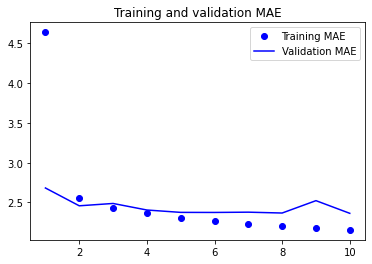

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [27]:
# Naive NumPy implementation of RNN

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t))
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)
with tf.device('/device:CPU:0'):
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=val_dataset,
        callbacks=callbacks
    )


Epoch 1/50


2022-05-05 16:53:58.054770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


: 

: 